In [1]:
import numpy as np
import os
import multiprocessing as mul
import matplotlib.pyplot as plt
from numba import jit, njit, prange, set_num_threads, vectorize, guvectorize, cuda
from tqdm import tqdm
from core.signal_bag import *
from core.stacking_analysis import *
from core.req_arrays import *
import pickle
import scipy.stats as st
import scipy.interpolate as interp

read icdata
read uptdata
read eadata
read mspdata


In [2]:
np.count_nonzero(np.abs(msdec) > 85)

2

In [3]:
mspdata

,NAME,RAJD,DECJD,P0,S1400,DIST,DIST_DM,Unnamed: 7
0,J0002+6216,0.742375,62.269278,0.115364,0.02,6.357,6.357,NaN
1,J0006+1834,1.520000,18.583056,0.693748,*,0.860,0.860,NaN
2,J0007+7303,1.757083,73.052056,0.315873,*,1.400,*,NaN
3,J0011+08,2.891667,8.166667,2.552870,*,5.399,5.399,NaN
4,J0012+5431,3.097083,54.529722,3.025301,*,5.425,5.425,NaN
...,...,...,...,...,...,...,...,...
3384,J2354-22,358.608333,-22.864722,0.557996,*,1.108,1.108,NaN
3385,B2351+61,358.519929,61.929679,0.944784,5.00,2.439,2.399,NaN
3386,J2355+0051,358.963702,0.852658,0.003719,0.16,0.958,0.958,NaN
3387,J2355+1523,358.952583,15.388333,1.094396,*,3.444,3.444,NaN


In [4]:
num_threads = int(mul.cpu_count()*0.9)
set_num_threads(num_threads)
# UNCOMMENT FOR LINEAR BINS
# all_enu = np.linspace(10**11.001, 10**18.999, 1000)
all_enu = e_nu_wall
cone_deg = 5.0
cone = np.deg2rad(cone_deg)
cut = cone

# enus = 0.5*(all_enu[1:]+all_enu[:-1])
# UNCOMMENT FOR DENSER LOGARITHMIC BINS, optimal nbins is 1e6
enus = np.logspace(11.001, 18.999, int(5e4))
enus_bin_indices = np.zeros(len(enus), dtype=np.int64)

for i in prange(len(enus)):
    enus_bin_indices[i] = np.digitize(enus[i], e_nu_wall) - 1
msdec_bin_indices = np.zeros(p, dtype=np.int64)
for i in prange(p):
    msdec_bin_indices[i] = np.digitize(msdec[i], dec_nu) - 1

for i in prange(len(enus)):
    enus_bin_indices[i] = np.digitize(enus[i], e_nu_wall) - 1
gamma_arr = [-2, -2.2, -2.53, -3]
phio = np.logspace(-38, -26, 1000) #CHANGING TO LINEAR BINS RESULTS IN STRAIGHT LINES

# print("\nNumber of threads: ", num_threads)
print("\nNumber of energy bins: ", len(enus))
print("\nNumber of phi bins: ", len(phio))
print("\nCalculating weights...\n\n")
eareaa = [i.astype(np.float64) for i in earea]
eareaa = np.asfarray(eareaa, dtype=np.float64)
eareaa[0][0]
earea2 = np.asfortranarray(earea)
earea2 = earea2[0].astype(np.float64)


Number of energy bins:  50000

Number of phi bins:  1000

Calculating weights...




In [5]:
altier_path = [os.getcwd() + '/pickle/', os.getcwd() + '/../pickle/']
@vectorize(['float64(int64, float64, int64)'], nopython=True, target='parallel')
def psr_wt_sing_gamma(psrno,gamma, season):

    tt_upt = t_upt[season]
    l = msdec_bin_indices[psrno]
    wt_ac_temp = np.zeros(len(enus), dtype=np.float64)
    for i in prange(len(enus)):
        wt_ac_temp[i] = np.float64(tt_upt * earea[ea_season(season)][l*40 + enus_bin_indices[i]] * (enus[i]**gamma))


    return np.trapz(wt_ac_temp, enus)

if f'wt_acc_{len(enus)}_bins_C_wt_cone_{cone_deg}.pkl' in os.listdir(altier_path[0]):# or f'wt_acc.pkl_{len(enus)}' in os.listdir(altier_path[1]):
    print("Loading wt_acc from pickle")
    
    with open(altier_path[0] + f'wt_acc_{len(enus)}_bins_C_wt_cone_{cone_deg}.pkl', 'rb') as f:
        wt_acc = pickle.load(f)
    
    
    print("Loaded wt_acc from pickle with nbins= ", len(enus))

else:
    print("Calculating wt_acc for all pulsars and seasons and gamma")
    wt_acc = []
    for gamma in prange(len(gamma_arr)):
        wt_allpsr = []
        for season in tqdm(prange(10)):
    

            wt_allpsr.append(np.array(psr_wt_sing_gamma(prange(p), gamma_arr[gamma], season), dtype=np.float64))
            # tmp = []
        wt_acc.append(wt_allpsr)
        wt_allpsr = []
        
    wt_acc = np.asfarray(wt_acc, dtype=np.float64)
    with open(altier_path[0] + f'wt_acc_{len(enus)}_bins_C_wt_cone_{cone_deg}.pkl', 'wb') as f:
        pickle.dump(wt_acc, f)
    print("Calculated wt_acc for all pulsars and seasons and gamma")
season_walls = np.asarray([0, 36900, 143911, 237044, 373288, 486146, 608687, 735732, 865043, 988700, 1134450])
season_widts= np.diff(season_walls)
#Compute the signal PDF for all neutrinos as per eqns 6, 7 and weights as per eqn 8 of 2205.15963

w_models = np.array([np.ones(p)])

@njit(nogil=True, parallel=True)
def S_ijk(nu): 

    '''
    Calculates S_ij as in EQN 7 of 2205.15963
    ----------

    Parameters
    ----------
    nu : int
        Index of the neutrino in the sample
        
    
    Returns
    -------
        Returns the signal PDF for the {psrno}th pulsar and nuind_inp neutrino
    '''
    
    
    
    # ang2 = hvovec(msra, msdec, icra[nu], icdec[nu], rad=True) ** 2      #rad**2
    # sg = np.deg2rad(icang[nu]) ** 2                                     #rad**2
    # return np.divide(np.exp(-1 * np.divide(ang2, 2*sg)), (2 * np.pi * sg))      #1/rad**2
    
    #SUGGESTION 0: SIGNAL PDF USES A CUT = CONE OF BGND PDF
    ang = hvovec(msra, msdec, icra[nu], icdec[nu], rad=True)
    
    sg = np.deg2rad(icang[nu]) ** 2                                     #rad**2
    sijk =  np.divide(np.exp(-1 * np.divide(ang ** 2, 2*sg)), (2 * np.pi * sg))      #1/rad**2
    for i in prange(len(msra)):
        if ang[i] > cone:
            sijk[i] = 0
            
    return sijk
    


@njit(nogil=True)
def S_ik(nu, weight, w_models, gamma_index, ws):

    '''
    
    Calculates S_i as in EQN 8 of 2205.15963
    ----------

    Parameters
    ----------
    nu : int
        Index of the neutrino in the sample

    normalized_wt : array
        Normalized weights of the pulsars


    gamma_index : int
        Index of the gamma value in the gamma array

    ws : int
        Index of the weight model

    Returns
    -------
        Returns the signal PDF for the {psrno}th pulsar and nuind_inp neutrino

    '''

    sij = S_ijk(nu)
    season = 0
    for i in range(10):
        if season_walls[i] <= nu and nu < season_walls[i+1]:
            season = i
            break

    return np.sum(np.multiply(sij, np.multiply(w_models[ws], weight[gamma_index][season])/np.sum(np.multiply(w_models[ws], weight[gamma_index][season]))))      #1/rad**2

@njit(parallel=True, nogil=True)
def Sik_sing_s_g(gamma_index, ws):#, wt_acc=wt_acc, w_models=w_models):
    '''
    Calculates S_i as in EQN 8 of 2205.15963
    ----------

    Parameters
    ----------
    weight : array
         weights of the pulsars

    season : int
        Season of the neutrino

    gamma_index : int
        Index of the gamma value in the gamma array

    ws : int
        Index of the weight model

    Returns
    -------
        Returns the signal PDF for the {psrno}th pulsar and nuind_inp neutrino
    '''



    tmp = []
    if ws == -1: #No weights
        for nu in prange(len(icra)):
            tmp.append(np.sum(S_ijk(nu)))
        return np.array(tmp, dtype=np.float64)

    for nu in prange(len(icra)):
        tmp.append(S_ik(nu, wt_acc, w_models, gamma_index, ws))
    return np.array(tmp, dtype=np.float64)


@vectorize(['float64(int64, int64)'], nopython=True,target='parallel')
def Bi_stacked_compute(nu, cone=cone):

    '''
    Calculates B_i as in EQN 9 of 2205.15963
    ----------

    Parameters
    ----------
    nu : int
        Index of the neutrino from IceCube sample
    cone : float
        Cone angle in degrees.
    

    Returns
    -------
    float
        Returns the background PDF for the {nu}th neutrino
    '''

    # count = np.sum(np.abs(np.subtract(icdec, icdec[nu])) <= cone)
    count=0
    for i in prange(len(icdec)):
        if abs(icdec[i] - icdec[nu]) <= cone:
            count+=1
    binwidth = (np.sin(np.deg2rad(icdec[nu] + cone)) - np.sin(np.deg2rad(icdec[nu] - cone)))*2*np.pi
    return count/(binwidth * N_ic)           #No units or sr**-1
#Pickle
if os.path.isfile(altier_path[0] + f'all_Bi_C_cone_{cone_deg}.pkl'):
    print("Loading all_Bi from pickle...")
    with open(altier_path[0] + f'all_Bi_C_cone_{cone_deg}.pkl', 'rb') as f:
        all_Bi = pickle.load(f)
    print("Loaded all_Bi from pickle")
else:
    print("\nCalculating Bi for all neutrinos\n")
    all_Bi = Bi_stacked_compute(np.arange(lnu), 5)
    # all_Bi+=1e-90
    print("\nCalculated Bi for all neutrinos")
    #Save to pickle
    with open(altier_path[0] + f'all_Bi_C_cone_{cone_deg}.pkl', 'wb') as f:
        pickle.dump(all_Bi, f)
        

@vectorize(['float64(int64, float64, float64, int64)'], nopython=True, target='parallel')
def ns_singleseason_sing_psr_HAT(psrno,gamma, phi0, season):
   

    tt_upt = t_upt[season]

        
    l = msdec_bin_indices[psrno]
     
        
    ns_temp = np.zeros(len(enus), dtype=np.float64)
    for i in prange(len(enus)):
        ns_temp[i] += np.float64(tt_upt * earea[ea_season(season)][l*40 + enus_bin_indices[i]] * phi0 * (enus[i]/(10**14))**gamma)
    # temp_ea = np.asarray(earea[ea_season(season)])[l*40 + k]
    # return tt_upt * temp_ea * phi0 * ((enu/(10**14))**gamma)     #in s cm2 eV

    return np.trapz(ns_temp, enus) 

Loading wt_acc from pickle
Loaded wt_acc from pickle with nbins=  50000
Loading all_Bi from pickle...
Loaded all_Bi from pickle


In [6]:
wt_acc.shape

(4, 10, 3389)

In [7]:
# @njit(nogil=True)
# def TS_for_all_psrs2(nsa):  
#     return Ts_arr2(nsa, t2mp, all_Bi, Ns) 


@jit(nopython=True)
def Pr(x, Ns, S, B):
    nsN = x/Ns
    return np.add(np.multiply(nsN , S), np.multiply(np.subtract(1, nsN), B))



@njit(nogil=True)
def TS_st_vec(x, S, B, Ns):
    nsN = x/Ns
    pr = np.add(np.multiply(nsN , S), np.multiply(np.subtract(1, nsN), B))
    return np.sum(np.asfarray(2*np.log(pr/B)))

lnu = 1134450
Ns = lnu#np.count_nonzero(nuind+1)




# W_MODEL=1 ONLY

In [8]:
if os.path.isfile(altier_path[0] + f'all_Si_ws_g_s_{len(enus)}_bins_C_wt_bins_C_wt_all_psr_wmod1_cone_{cone_deg}.pkl'):
    print("Loading all_Si_ws_g_s from pickle")
    with open(altier_path[0] + f'all_Si_ws_g_s_{len(enus)}_bins_C_wt_bins_C_wt_all_psr_wmod1_cone_{cone_deg}.pkl', 'rb') as f:
        all_Si_ws_g_s = pickle.load(f)
    print("Loaded all_Si_ws_g_s from pickle with nbins =", len(enus))
else:


    print("\nCalculating S_i for all neutrinos and gammas and weighting schemes...\n")

    all_Si_ws_g_s = []
    # tmp = []
    tmp_wt_acc = []
    # tmp_wt_acc_w_dist = []
    # tmp_wt_acc_w_s1400 = []

    for gamma_index in tqdm(prange(4)):
        # for season in tqdm(prange(10)):
        # tmp.append(Sik_sing_s_g(gamma_index, -1))
        tmp_wt_acc.append(Sik_sing_s_g(gamma_index, 0))
        # tmp_wt_acc_w_dist.append(Sik_sing_s_g(gamma_index, 1))
        # tmp_wt_acc_w_s1400.append(Sik_sing_s_g(gamma_index, 2))


    # all_Si_ws_g_s.append([tmp_wt_acc, tmp_wt_acc_w_dist, tmp_wt_acc_w_s1400])
    all_Si_ws_g_s.append([tmp_wt_acc])
    # tmp = []
    tmp_wt_acc = []
    # tmp_wt_acc_w_dist = []
    # tmp_wt_acc_w_s1400 = []
    all_Si_ws_g_s = np.asfarray(all_Si_ws_g_s[0])

    print("Calculated S_i for all neutrinos and gammas and weighting schemes")
    #Save to pickle
    with open(altier_path[0] + f'all_Si_ws_g_s_{len(enus)}_bins_C_wt_bins_C_wt_all_psr_wmod1_cone_{cone_deg}.pkl', 'wb') as f:
        pickle.dump(all_Si_ws_g_s, f)


Calculating S_i for all neutrinos and gammas and weighting schemes...



100%|██████████| 4/4 [01:32<00:00, 23.22s/it]

Calculated S_i for all neutrinos and gammas and weighting schemes


### ns

In [9]:
len(enus)

50000

In [10]:
def ns_HAT_all_season_all_psr_sing_gamma_wt_wtht_weights(gamma, e_nus=enus, phi0=1):
    ns_hat = 0
    ns_hat_wt = 0

    for season in tqdm(prange(10)):

        ns_hat = ns_singleseason_sing_psr_HAT(prange(p), gamma, phi0, season)
        ns_hat_wt += ns_hat

    return np.array([np.sum(ns_hat_wt)], dtype=np.float64)
#Pickle
arr = []
if os.path.isfile(altier_path[0] + f'ns_all_ws_{len(enus)}_bins_C_wt_bins_C_wt_all_psr_wmod1_cone_{cone_deg}.pkl'):
    print("Loading ns_hat from pickle...")
    with open(altier_path[0] + f'ns_all_ws_{len(enus)}_bins_C_wt_bins_C_wt_all_psr_wmod1_cone_{cone_deg}.pkl', 'rb') as f:
        arr = pickle.load(f)
    print("Loaded ns_hat from pickle with nbins =", len(enus))
else:
    print("\nCalculating ns_HAT for all gamma and weighting schemes...\n")

    arr=[]
    for gamma in prange(len(gamma_arr)):
        tmp = ns_HAT_all_season_all_psr_sing_gamma_wt_wtht_weights(gamma_arr[gamma])
        np.savetxt('outputs/ns_hat_wt_wt_gamma_{}.txt'.format(gamma_arr[gamma]), tmp)
        arr.append(tmp)
        tmp = []

    arr = np.array(arr, dtype=np.float64)
    with open(altier_path[0] + f'ns_all_ws_{len(enus)}_bins_C_wt_bins_C_wt_all_psr_wmod1_cone_{cone_deg}.pkl', 'wb') as f:
        pickle.dump(arr, f)
    print("\nCalculationed ns_HAT for all gamma and weighting schemes")



Calculating ns_HAT for all gamma and weighting schemes...



100%|██████████| 10/10 [00:05<00:00,  1.89it/s]


Calculationed ns_HAT for all gamma and weighting schemes


In [11]:
print('\nCALCULATING TS FOR ALL PSRS FOR ALL GAMMAS FOR ALL WEIGHTS\n')
all_TSS_wmod1 = []
for gamma in prange(len(gamma_arr)):
    print("gamma = {}".format(gamma))
    # tmp = np.zeros(len(phio))
    # for season in tqdm(range(10)):
    t2mp = np.asfarray(all_Si_ws_g_s[0][gamma])
    @njit(nogil=True)
    def TS_for_all_psrs2(nsa):  
        return TS_st_vec(nsa, t2mp, all_Bi, Ns)      #No units
    temp = []
    for phi in tqdm(prange(len(phio))):
        temp.append(TS_for_all_psrs2(arr[gamma]*phio[phi]))
    all_TSS_wmod1.append(temp)
    temp = []

print('\nCALCULATED TS FOR ALL PSRS FOR ALL GAMMAS FOR ALL WEIGHTS')



all_TSS_wmod1 = np.array(all_TSS_wmod1, dtype=np.float64)


for g in range(len(gamma_arr)):
    print(min(all_TSS_wmod1[g]), max(all_TSS_wmod1[g]))
    # np.savetxt(f'TS_w{w}_g{g}.txt', all_TSS[w][g])
    
    print('wt\n')

# with open(altier_path[0] + f'all_TSS_{len(enus)}_bins_C_wt_bins_C_wt_all_psr_wmod1_cone_{cone_deg}.pkl', 'wb') as f:
    # pickle.dump(all_TSS_wmod1, f)


CALCULATING TS FOR ALL PSRS FOR ALL GAMMAS FOR ALL WEIGHTS

gamma = 0


100%|██████████| 1000/1000 [00:07<00:00, 134.80it/s]


gamma = 1


100%|██████████| 1000/1000 [00:07<00:00, 140.46it/s]


gamma = 2


100%|██████████| 1000/1000 [00:07<00:00, 138.99it/s]


gamma = 3


100%|██████████| 1000/1000 [00:07<00:00, 136.11it/s]


CALCULATED TS FOR ALL PSRS FOR ALL GAMMAS FOR ALL WEIGHTS
-5706936.4878503205 -1.6726501363674583e-08
wt

-7217639.112619492 -2.5672530279830864e-08
wt

-5680090.056369393 -9.39320948498617e-08
wt

-7700996.298846167 -7.715710941247164e-07
wt



In [12]:
all_TSS_wmod1[1]

array([-2.56725303e-08, -2.63708277e-08, -2.72294853e-08, -2.78417423e-08,
       -2.87966760e-08, -2.94291439e-08, -3.03176025e-08, -3.12890146e-08,
       -3.21617017e-08, -3.29998615e-08, -3.38643940e-08, -3.48111145e-08,
       -3.58874365e-08, -3.68851526e-08, -3.78448377e-08, -3.90478612e-08,
       -4.00159235e-08, -4.12725855e-08, -4.23255815e-08, -4.34352808e-08,
       -4.48514138e-08, -4.60625573e-08, -4.73041398e-08, -4.85550397e-08,
       -5.00359636e-08, -5.14562487e-08, -5.27706063e-08, -5.41755847e-08,
       -5.58588628e-08, -5.74967169e-08, -5.90076802e-08, -6.05530637e-08,
       -6.22840430e-08, -6.40912939e-08, -6.58538888e-08, -6.76923947e-08,
       -6.97172812e-08, -7.15254234e-08, -7.37070227e-08, -7.55824569e-08,
       -7.77217159e-08, -7.99219166e-08, -8.22259919e-08, -8.44051872e-08,
       -8.69777650e-08, -8.94389545e-08, -9.17731960e-08, -9.44546989e-08,
       -9.69354483e-08, -9.96605854e-08, -1.02551506e-07, -1.05518300e-07,
       -1.08451453e-07, -

3.798215306190736e-27
3.2174181506763517e-27
1.5246957270175698e-27
1e-19
1e-19
1e-19

TS_vs_E2dfde_all_w_model_bins=50000_C_wt_all_psr_wmod1_cone_5.0.pdf
DONE


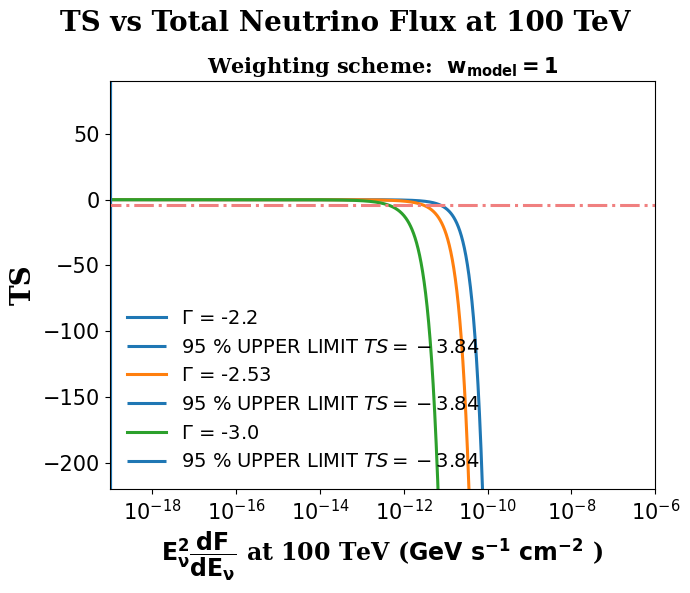

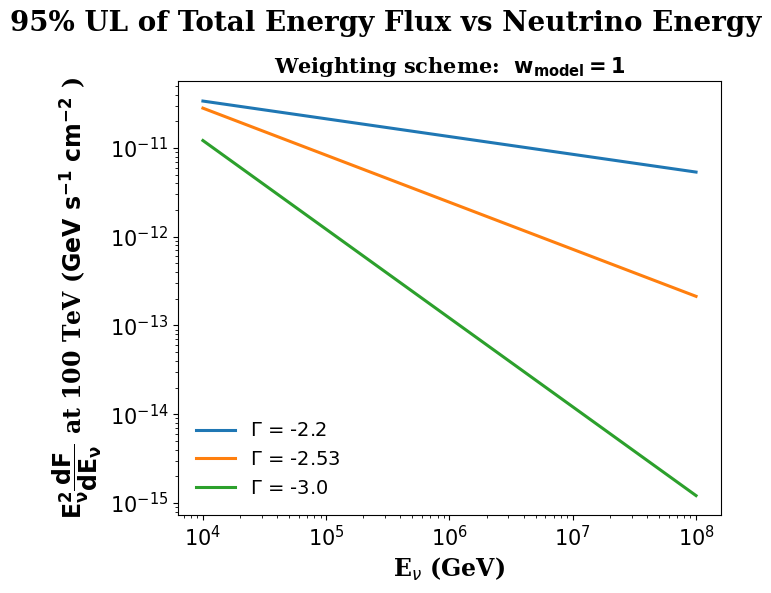

In [13]:
all_TSS_wmod1 = np.asarray(all_TSS_wmod1)
gamma_arr = np.asarray(gamma_arr)

all_e_UL = []
e_decade = [1e13, 1e14, 1e15, 1e16, 1e17]
for e_UL in e_decade:
    e2dfde = []

    for gamma in prange(len(gamma_arr)):
        temp = []
        for phi in range(len(phio)):
            temp.append( e_UL**2 * dfde(e_UL, gamma_arr[gamma], phio[phi]))        #in eV
        e2dfde.append(temp)
    e2dfde = np.asarray(e2dfde)

    all_e_UL.append(e2dfde)
mark = ['^', 'o', 's', 'd']


for g in range(3):
    print(phio[np.argmax(all_TSS_wmod1[g])]) 


all_UL = []

for gamma in prange(len(gamma_arr)):
    temp = []
    for i in all_e_UL:
        dist_g = interp.interp1d(all_TSS_wmod1[gamma], i[gamma]/1e9)
        temp.append(dist_g(-3.84))

        
    all_UL.append(temp)
e2dfde = np.asarray([1e28 * dfde(1e14, g, 1) * phio for g in gamma_arr])
# plt.style.use('default')
font = {'family': 'serif',
        'weight': 'bold',
        'size': 22,
        'color':  'black',
        }
smallerfont = {'family': 'serif',
        'color':  'black',
        'weight': 'bold',
        'size': 15,
        }

axesfont = {'family': 'serif',
        'color':  'black',
        'weight': 'bold',
        'size': 17,
        }

fig, axs = plt.subplots(1,1, figsize=(7, 6))

for gamma in [ 1, 2, 3]:#range(4):
    
    axs.plot(1e28 * dfde(1e14, gamma_arr[gamma], 1) *phio /1e9, all_TSS_wmod1[gamma], label='$\Gamma$ = ' + str(gamma_arr[gamma]), lw=2.2)# + ' with wt')    #in GeV
    axs.vlines(1e19*phio[np.nanargmax(all_TSS_wmod1[gamma])], -1e7, 90,lw=2.2, label='95 % UPPER LIMIT $TS = -3.84$')
    print(1e19*phio[np.nanargmax(all_TSS_wmod1[gamma])])
    

axs.set_title('Weighting scheme:  $\mathsf{\mathbf{w_{model} = 1}}$', fontdict=smallerfont)


# for i in range(3):
    
axs.legend(prop={'size':14}, framealpha=0, loc='lower left')
axs.hlines(-3.84, 1e-20, 1e-5, linestyles='dashed', lw=2.2, ls='-.', label='95 % UPPER LIMIT $TS = -3.84$', color='lightcoral')
axs.set_xscale('log')
axs.set_xlabel('$\mathsf{\mathbf{E^2_{\u03BD} \dfrac{dF}{dE_{\u03BD}}}}$ at 100 TeV ($\mathsf{\mathbf{GeV}}$ $\mathsf{\mathbf{s^{-1}}}$ $\mathsf{\mathbf{cm^{-2}}}$ )', fontdict=axesfont)
axs.set_ylabel('TS', fontdict=axesfont, fontsize=20)
axs.xaxis.set_tick_params(labelsize=15)
axs.yaxis.set_tick_params(labelsize=15)

axs.set_ylim(-220, 90)
axs.set_xlim(0.95e-19, 1e-6)

plt.suptitle('TS vs Total Neutrino Flux at 100 TeV', fontweight='bold', fontsize=20, fontfamily='serif')

plt.tight_layout()
plt.savefig(f'outputs/TS_vs_E2dfde_all_w_model_bins={len(enus)}_C_wt_all_psr_wmod1_cone_{cone_deg}.pdf')
# plt.show()
print(f'\nTS_vs_E2dfde_all_w_model_bins={len(enus)}_C_wt_all_psr_wmod1_cone_{cone_deg}.pdf\nDONE')


#SIMILAR PLOTS FOR 95% UPPER LIMIT 
fig, axs = plt.subplots(1, 1, figsize=(7, 6))




for gamma in range(1, len(gamma_arr)):

    axs.plot(np.divide(e_decade, 1e9), np.multiply(all_UL[gamma], 3), label='$\Gamma$ = ' + str(gamma_arr[gamma]), lw=2.2, ls='-')# + ' with wt')    #in GeV

    
axs.set_xscale('log')
axs.set_yscale('log')
axs.set_xlabel('E$_{\u03BD}$ (GeV)', fontdict=axesfont)
axs.set_ylabel('$\mathsf{\mathbf{E^2_{\u03BD} \dfrac{dF}{dE_{\u03BD}}}}$ at 100 TeV ($\mathsf{\mathbf{GeV}}$ $\mathsf{\mathbf{s^{-1}}}$ $\mathsf{\mathbf{cm^{-2}}}$ )', fontdict=axesfont)
axs.xaxis.set_tick_params(labelsize=15)
axs.yaxis.set_tick_params(labelsize=15)

axs.legend(prop={'size':14}, framealpha=0, loc='lower left')


axs.set_title('Weighting scheme:  $\mathsf{\mathbf{w_{model} = 1}}$', fontdict=smallerfont)


plt.suptitle('95% UL of Total Energy Flux vs Neutrino Energy', fontweight='bold', fontsize=20, fontfamily='serif')
plt.tight_layout()
plt.savefig(f'outputs/UL_all_w_model_bins={len(enus)}_C_wt_all_psr_wmod1_cone_{cone_deg}.pdf')
plt.show()

In [14]:
for i in all_TSS_wmod1:
    print(max(i), np.argmax(i), 1e19 * np.logspace(-38, -26, 1000)[np.argmax(i)])

-1.6726501363674583e-08 964 3.798215306190736e-08
-2.5672530279830864e-08 958 3.2174181506763516e-08
-9.39320948498617e-08 931 1.5246957270175697e-08
-7.715710941247164e-07 871 2.9004304938639856e-09


In [15]:
phio[np.argmax(all_TSS_wmod1[0])]

3.798215306190736e-27

# W_MODEL = 1/d2 and s1400

### Signal

In [16]:
wds_index = [i for i in range(len(mspdata)) if mspdata['DIST_DM'][i] != '*' and mspdata['S1400'][i] != '*']
wt_acc2 = []
for i in range(len(wt_acc)):
    tmp = []
    for j in range(len(wt_acc[i])):
        tmp.append(wt_acc[i][j][wds_index])
    wt_acc2.append(tmp)
    
wt_acc2 = np.asfarray(wt_acc2)
wt_acc = wt_acc2

rererere = readfiles.Data(os.getcwd() + '/data/').mspdata

rererere

In [17]:
mspdata = mspdata[mspdata['DIST_DM'] != '*']
mspdata = mspdata[mspdata['S1400'] != '*']
msdist = np.array(mspdata['DIST_DM'], dtype=np.float64)
mss1400 = np.array(mspdata['S1400'], dtype=np.float64)
w_models = np.column_stack([1/(msdist**2), mss1400]).T.astype(np.float64)
sum_wt_model = [1, np.sum(1/(msdist**2)), np.sum(mss1400)]

msra = np.array(mspdata['RAJD'], dtype=np.float64)
msdec = np.array(mspdata['DECJD'], dtype=np.float64)
p = len(mspdata)

In [18]:
np.count_nonzero(np.abs(msdec) > 85)

0

In [19]:
if os.path.isfile(altier_path[0] + f'all_Si_ws_g_s_{len(enus)}_bins_C_wt_cone_{cone_deg}.pkl'):
    print("Loading all_Si_ws_g_s from pickle")
    with open(altier_path[0] + f'all_Si_ws_g_s_{len(enus)}_bins_C_wt_cone_{cone_deg}.pkl', 'rb') as f:
        all_Si_ws_g_s = pickle.load(f)
    print("Loaded all_Si_ws_g_s from pickle with nbins =", len(enus))
else:


    print("\nCalculating S_i for all neutrinos and gammas and weighting schemes...\n")

    all_Si_ws_g_s = []
    # tmp = []
    # tmp_wt_acc = []
    tmp_wt_acc_w_dist = []
    tmp_wt_acc_w_s1400 = []

    for gamma_index in tqdm(prange(4)):
        # for season in tqdm(prange(10)):
        # tmp.append(Sik_sing_s_g(gamma_index, -1))
        # tmp_wt_acc.append(Sik_sing_s_g(gamma_index, 0))
        tmp_wt_acc_w_dist.append(Sik_sing_s_g(gamma_index, 1))
        tmp_wt_acc_w_s1400.append(Sik_sing_s_g(gamma_index, 2))


    all_Si_ws_g_s.append([tmp_wt_acc_w_dist, tmp_wt_acc_w_s1400])
    # tmp = []
    # tmp_wt_acc = []
    tmp_wt_acc_w_dist = []
    tmp_wt_acc_w_s1400 = []
    all_Si_ws_g_s = np.asfarray(all_Si_ws_g_s[0])

    print("Calculated S_i for all neutrinos and gammas and weighting schemes")
    #Save to pickle
    with open(altier_path[0] + f'all_Si_ws_g_s_{len(enus)}_bins_C_wt_cone_{cone_deg}.pkl', 'wb') as f:
        pickle.dump(all_Si_ws_g_s, f)


Calculating S_i for all neutrinos and gammas and weighting schemes...



100%|██████████| 4/4 [02:31<00:00, 37.86s/it]

Calculated S_i for all neutrinos and gammas and weighting schemes


### ns

In [20]:
def ns_HAT_all_season_all_psr_sing_gamma_wt_d2_s1400_wtht_weights(gamma, e_nus=enus, phi0=1):
    ns_hat = 0
    ns_hat_wt = 0
    ns_hat_wt_dist = 0
    ns_hat_wt_s1400 = 0
    for season in tqdm(prange(10)):

        ns_hat = ns_singleseason_sing_psr_HAT(prange(p), gamma, phi0, season)
        ns_hat_wt += ns_hat
        ns_hat_wt_dist += np.dot(w_models[0]/ np.sum(w_models[0]) , ns_hat)
        ns_hat_wt_s1400 += np.dot(w_models[1]/ np.sum(w_models[1]), ns_hat)
    return np.array([ns_hat_wt_dist, ns_hat_wt_s1400], dtype=np.float64)
#Pickle
arr = []
if os.path.isfile(altier_path[0] + f'ns_all_ws_{len(enus)}_bins_C_wt_cone_{cone_deg}.pkl'):
    print("Loading ns_hat from pickle...")
    with open(altier_path[0] + f'ns_all_ws_{len(enus)}_bins_C_wt_cone_{cone_deg}.pkl', 'rb') as f:
        arr = pickle.load(f)
    print("Loaded ns_hat from pickle with nbins =", len(enus))
else:
    print("\nCalculating ns_HAT for all gamma and weighting schemes...\n")

    arr=[]
    for gamma in prange(len(gamma_arr)):
        tmp = ns_HAT_all_season_all_psr_sing_gamma_wt_d2_s1400_wtht_weights(gamma_arr[gamma])
        np.savetxt('outputs/ns_hat_wt_wt_gamma_{}.txt'.format(gamma_arr[gamma]), tmp)
        arr.append(tmp)
        tmp = []

    arr = np.array(arr, dtype=np.float64)
    with open(altier_path[0] + f'ns_all_ws_{len(enus)}_bins_C_wt_cone_{cone_deg}.pkl', 'wb') as f:
        pickle.dump(arr, f)
    print("\nCalculationed ns_HAT for all gamma and weighting schemes")
    
    
    
    
print('\nCALCULATING TS FOR ALL PSRS FOR ALL GAMMAS FOR ALL WEIGHTS\n')

all_TSS_wt_d2_wt_s = []
for ws in prange(2):
    tmpp = []
    print("ws = {}".format(ws))
    for gamma in prange(len(gamma_arr)):
        print("gamma = {}".format(gamma))
        # tmp = np.zeros(len(phio))
        # for season in tqdm(range(10)):
        t2mp = np.asfarray(all_Si_ws_g_s[ws][gamma])
        @njit(nogil=True)
        def TS_for_all_psrs2(nsa):  
            return TS_st_vec(nsa, t2mp, all_Bi, Ns)      #No units
        temp = []
        for phi in tqdm(prange(len(phio))):
            temp.append(TS_for_all_psrs2(arr[gamma][ws]*phio[phi]))
        tmpp.append(temp)
        temp = []
    all_TSS_wt_d2_wt_s.append(tmpp)
    tmpp = []

print('\nCALCULATED TS FOR ALL PSRS FOR ALL GAMMAS FOR ALL WEIGHTS')



all_TSS_wt_d2_wt_s = np.array(all_TSS_wt_d2_wt_s, dtype=np.float64)



Calculating ns_HAT for all gamma and weighting schemes...



100%|██████████| 10/10 [00:03<00:00,  2.95it/s]



Calculationed ns_HAT for all gamma and weighting schemes

CALCULATING TS FOR ALL PSRS FOR ALL GAMMAS FOR ALL WEIGHTS

ws = 0
gamma = 0


100%|██████████| 1000/1000 [00:07<00:00, 139.88it/s]


gamma = 1


100%|██████████| 1000/1000 [00:06<00:00, 145.54it/s]


gamma = 2


100%|██████████| 1000/1000 [00:06<00:00, 146.36it/s]


gamma = 3


100%|██████████| 1000/1000 [00:06<00:00, 146.07it/s]


ws = 1
gamma = 0


100%|██████████| 1000/1000 [00:06<00:00, 148.52it/s]


gamma = 1


100%|██████████| 1000/1000 [00:07<00:00, 142.65it/s]


gamma = 2


100%|██████████| 1000/1000 [00:06<00:00, 147.72it/s]


gamma = 3


100%|██████████| 1000/1000 [00:07<00:00, 139.84it/s]


CALCULATED TS FOR ALL PSRS FOR ALL GAMMAS FOR ALL WEIGHTS



TS_vs_E2dfde_all_w_model_bins=50000_C_wt.pdf
DONE


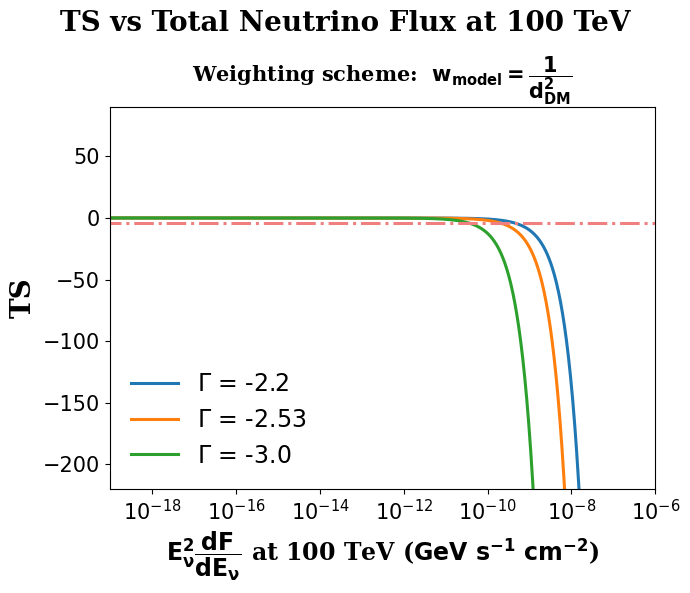

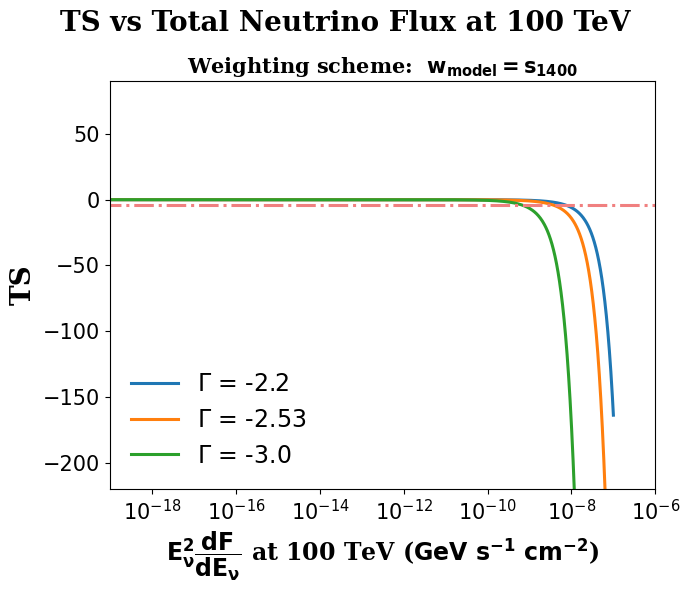

In [21]:
font = {'family': 'serif',
        'weight': 'bold',
        'size': 22,
        'color':  'black',
        }
smallerfont = {'family': 'serif',
        'color':  'black',
        'weight': 'bold',
        'size': 15,
        }

axesfont = {'family': 'serif',
        'color':  'black',
        'weight': 'bold',
        'size': 17,
        }
for i in range(2):
        fig, axs = plt.subplots(1,1, figsize=(7, 6))

        for gamma in [ 1, 2, 3]:#range(4):
        
        
                axs.plot( 1e28 * dfde(1e14, gamma_arr[gamma], 1) *phio /1e9, all_TSS_wt_d2_wt_s[i][gamma], label='$\Gamma$ = ' + str(gamma_arr[gamma]), lw=2.2)# + ' with wt')    #in GeV

        

        axs.set_title(['Weighting scheme:  $\mathsf{\mathbf{w_{model} = \dfrac{1}{d_{DM}^2}}}$', 'Weighting scheme:  $\mathsf{\mathbf{w_{model} = s_{1400}}}$'][i] , fontdict=smallerfont)


                
        axs.legend(prop={'size':17}, framealpha=0, loc='lower left')
        axs.hlines(-3.84, 1e-20, 1e-5, linestyles='dashed', lw=2.2, ls='-.', label='95 % UPPER LIMIT $TS = -3.84$', color='lightcoral')
        axs.set_xscale('log')
        axs.set_xlabel('$\mathsf{\mathbf{E^2_{\u03BD} \dfrac{dF}{dE_{\u03BD}}}}$ at 100 TeV ($\mathsf{\mathbf{GeV}}$ $\mathsf{\mathbf{s^{-1}}}$ $\mathsf{\mathbf{cm^{-2}}}$)', fontdict=axesfont)
        axs.set_ylabel('TS', fontdict=axesfont, fontsize=20)
        axs.xaxis.set_tick_params(labelsize=15)
        axs.yaxis.set_tick_params(labelsize=15)
        
        axs.set_ylim(-220, 90)
        axs.set_xlim(0.95e-19, 1e-6)

        plt.suptitle('TS vs Total Neutrino Flux at 100 TeV', fontweight='bold', fontsize=20, fontfamily='serif')

        plt.tight_layout()
        plt.savefig(f'outputs/TS_vs_E2dfde_all_w_model_bins={len(enus)}_C_wmodel{i+2}.pdf')
# plt.show()
print(f'\nTS_vs_E2dfde_all_w_model_bins={len(enus)}_C_wt.pdf\nDONE')

In [22]:
#after wt_acc mod
c=2
for w in all_TSS_wt_d2_wt_s:
    print(c)
    for i in w[1:]:
        print(max(i), np.argmax(i), 1e19 * phio[np.argmax(i)])
    c+=1

2
-8.581582111821581e-10 6 1.180516528568813e-19
-1.934865601158098e-09 1 1.0280447320933161e-19
-1.069516853117067e-08 0 1e-19
3
6.863087875731972e-11 26 2.0526377527092648e-19
1.727995524383008e-11 6 1.180516528568813e-19
-4.4354031560106666e-10 947 2.373424250023876e-08


In [23]:
#before wt_acc mod
c=2
for w in all_TSS_wt_d2_wt_s:
    print(c)
    for i in w[1:]:
        print(max(i), np.argmax(i), 1e19 * phio[np.argmax(i)])
    c+=1

2
-8.581582111821581e-10 6 1.180516528568813e-19
-1.934865601158098e-09 1 1.0280447320933161e-19
-1.069516853117067e-08 0 1e-19
3
6.863087875731972e-11 26 2.0526377527092648e-19
1.727995524383008e-11 6 1.180516528568813e-19
-4.4354031560106666e-10 947 2.373424250023876e-08


# ALL PLOTS

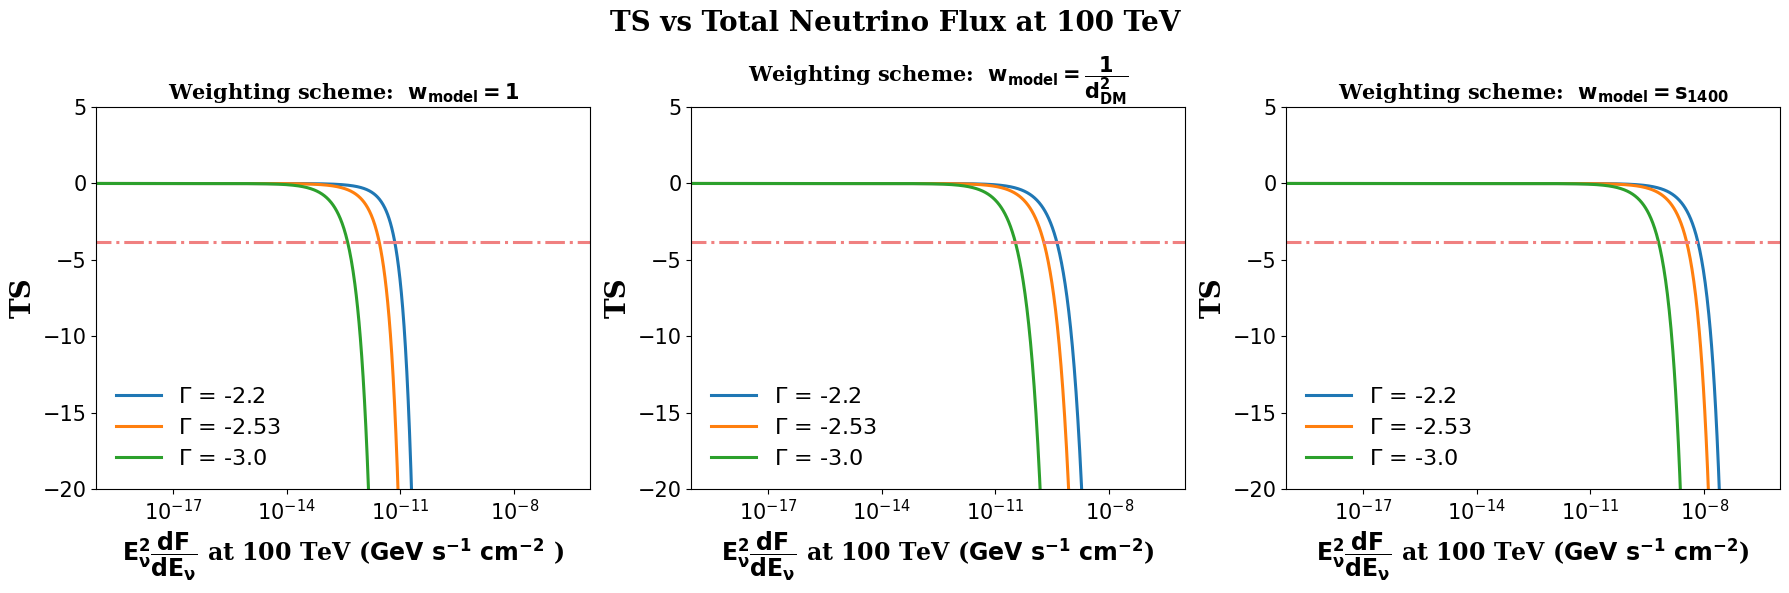

In [30]:
fig, axs = plt.subplots(1,3, figsize=(18, 6))

for gamma in [ 1, 2, 3]:#range(4):
    
    axs[0].plot(1e28 * dfde(1e14, gamma_arr[gamma], 1) *phio /1e9, all_TSS_wmod1[gamma], label='$\Gamma$ = ' + str(gamma_arr[gamma]), lw=2.2)# + ' with wt')    #in GeV

    

axs[0].set_title('Weighting scheme:  $\mathsf{\mathbf{w_{model} = 1}}$', fontdict=smallerfont)



    
axs[0].legend(prop={'size':16}, framealpha=0, loc='lower left')
axs[0].hlines(-3.84, 1e-20, 1e-5, linestyles='dashed', lw=2.2, ls='-.', label='95 % UPPER LIMIT $TS = -3.84$', color='lightcoral')
axs[0].set_xscale('log')
axs[0].set_xlabel('$\mathsf{\mathbf{E^2_{\u03BD} \dfrac{dF}{dE_{\u03BD}}}}$ at 100 TeV ($\mathsf{\mathbf{GeV}}$ $\mathsf{\mathbf{s^{-1}}}$ $\mathsf{\mathbf{cm^{-2}}}$ )', fontdict=axesfont)
axs[0].set_ylabel('TS', fontdict=axesfont, fontsize=20)
axs[0].xaxis.set_tick_params(labelsize=15)
axs[0].yaxis.set_tick_params(labelsize=15)

axs[0].set_ylim(-20, 5)
axs[0].set_xlim(0.95e-19, 1e-6)

for i in range(1, 3):

        for gamma in [ 1, 2, 3]:#range(4):
        
        
                axs[i].plot( 1e28 * dfde(1e14, gamma_arr[gamma], 1) *phio /1e9, all_TSS_wt_d2_wt_s[i-1][gamma], label='$\Gamma$ = ' + str(gamma_arr[gamma]), lw=2.2)# + ' with wt')    #in GeV

        

        axs[i].set_title(['Weighting scheme:  $\mathsf{\mathbf{w_{model} = \dfrac{1}{d_{DM}^2}}}$', 'Weighting scheme:  $\mathsf{\mathbf{w_{model} = s_{1400}}}$'][i-1] , fontdict=smallerfont)


                
        axs[i].legend(prop={'size':16}, framealpha=0, loc='lower left')
        axs[i].hlines(-3.84, 1e-20, 1e-5, linestyles='dashed', lw=2.2, ls='-.', label='95 % UPPER LIMIT $TS = -3.84$', color='lightcoral')
        axs[i].set_xscale('log')
        axs[i].set_xlabel('$\mathsf{\mathbf{E^2_{\u03BD} \dfrac{dF}{dE_{\u03BD}}}}$ at 100 TeV ($\mathsf{\mathbf{GeV}}$ $\mathsf{\mathbf{s^{-1}}}$ $\mathsf{\mathbf{cm^{-2}}}$)', fontdict=axesfont)
        axs[i].set_ylabel('TS', fontdict=axesfont, fontsize=20)
        axs[i].xaxis.set_tick_params(labelsize=15)
        axs[i].yaxis.set_tick_params(labelsize=15)
        
        axs[i].set_ylim(-20, 5)
        axs[i].set_xlim(0.95e-19, 1e-6)

plt.suptitle('TS vs Total Neutrino Flux at 100 TeV', fontweight='bold', fontsize=20, fontfamily='serif')

plt.tight_layout()
plt.savefig(f'outputs/TS_vs_E2dfde_all_w_model_bins={len(enus)}_C_wmodel_all.pdf')



In [31]:

all_e_UL_wmodel1 = []
e_decade = [1e13, 1e14, 1e15, 1e16, 1e17]
for e_UL in e_decade:
    e2dfde = []

    for gamma in prange(len(gamma_arr)):
        temp = []
        for phi in range(len(phio)):
            temp.append( e_UL**2 * dfde(e_UL, gamma_arr[gamma], phio[phi]))        #in eV
        e2dfde.append(temp)
    e2dfde = np.asarray(e2dfde)

    all_e_UL_wmodel1.append(e2dfde)
mark = ['^', 'o', 's', 'd']


for g in range(3):
    print(phio[np.argmax(all_TSS_wmod1[g])]) 


all_UL_wmodel1 = []

for gamma in prange(len(gamma_arr)):
    temp = []
    for i in all_e_UL_wmodel1:
        dist_g = interp.interp1d(all_TSS_wmod1[gamma], i[gamma]/1e9)
        temp.append(dist_g(-3.84))

        
    all_UL_wmodel1.append(temp)

3.798215306190736e-27
3.2174181506763517e-27
1.5246957270175698e-27


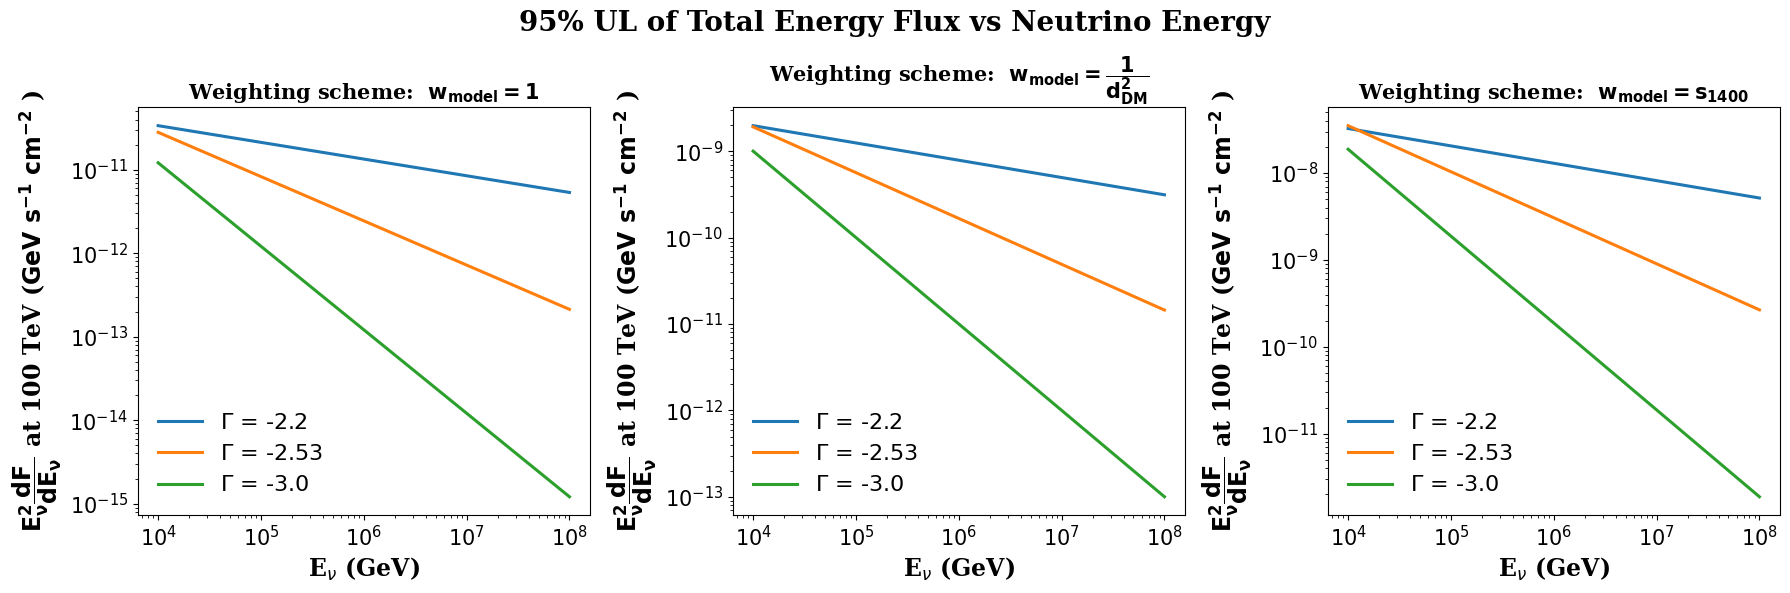

In [32]:
all_e_UL = []
e_decade = [1e13, 1e14, 1e15, 1e16, 1e17]
for e_UL in e_decade:
    e2dfde = []

    for gamma in prange(len(gamma_arr)):
        temp = []
        for phi in range(len(phio)):
            temp.append( e_UL**2 * dfde(e_UL, gamma_arr[gamma], phio[phi]))        #in eV
        e2dfde.append(temp)
    e2dfde = np.asarray(e2dfde)

    all_e_UL.append(e2dfde)
mark = ['^', 'o', 's', 'd']







all_UL_wd_ws = []
for ws in range(2):
    ul_all_gamma = []
    for gamma in prange(len(gamma_arr)):
        temp = []
        for i in all_e_UL:
            dist_g = interp.interp1d(all_TSS_wt_d2_wt_s[ws][gamma], i[gamma]/1e9)
            temp.append(dist_g(-3.84))

        ul_all_gamma.append(temp)
    all_UL_wd_ws.append(ul_all_gamma)
e2dfde = all_e_UL[1]
# plt.style.use('default')

#SIMILAR PLOTS FOR 95% UPPER LIMIT 
fig, axs = plt.subplots(1,3, figsize=(18, 6))


for gamma in range(1, len(gamma_arr)):
    
    axs[0].plot(np.divide(e_decade, 1e9), np.multiply(all_UL[gamma], 3), label='$\Gamma$ = ' + str(gamma_arr[gamma]), lw=2.2, ls='-')# + ' with wt')    #in GeV

    
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_xlabel('E$_{\u03BD}$ (GeV)', fontdict=axesfont)
axs[0].set_ylabel('$\mathsf{\mathbf{E^2_{\u03BD} \dfrac{dF}{dE_{\u03BD}}}}$ at 100 TeV ($\mathsf{\mathbf{GeV}}$ $\mathsf{\mathbf{s^{-1}}}$ $\mathsf{\mathbf{cm^{-2}}}$ )', fontdict=axesfont)
axs[0].xaxis.set_tick_params(labelsize=15)
axs[0].yaxis.set_tick_params(labelsize=15)

axs[0].legend(prop={'size':16}, framealpha=0, loc='lower left')


axs[0].set_title('Weighting scheme:  $\mathsf{\mathbf{w_{model} = 1}}$', fontdict=smallerfont)















for i in range(1,3):
    for gamma in range(1, len(gamma_arr)):

        axs[i].plot(np.divide(e_decade, 1e9), np.multiply(all_UL_wd_ws[i-1][gamma], 3), label='$\Gamma$ = ' + str(gamma_arr[gamma]), lw=2.2, ls='-')# + ' with wt')    #in GeV

    
    axs[i].set_xscale('log')
    axs[i].set_yscale('log')
    axs[i].set_xlabel('E$_{\u03BD}$ (GeV)', fontdict=axesfont)
    axs[i].set_ylabel('$\mathsf{\mathbf{E^2_{\u03BD} \dfrac{dF}{dE_{\u03BD}}}}$ at 100 TeV ($\mathsf{\mathbf{GeV}}$ $\mathsf{\mathbf{s^{-1}}}$ $\mathsf{\mathbf{cm^{-2}}}$ )', fontdict=axesfont)
    axs[i].xaxis.set_tick_params(labelsize=15)
    axs[i].yaxis.set_tick_params(labelsize=15)
    
    axs[i].legend(prop={'size':16}, framealpha=0, loc='lower left')


axs[0].set_title('Weighting scheme:  $\mathsf{\mathbf{w_{model} = 1}}$', fontdict=smallerfont)
axs[1].set_title('Weighting scheme:  $\mathsf{\mathbf{w_{model} = \dfrac{1}{d_{DM}^2}}}$' , fontdict=smallerfont)
axs[2].set_title('Weighting scheme:  $\mathsf{\mathbf{w_{model} = s_{1400}}}$', fontdict=smallerfont)


plt.suptitle('95% UL of Total Energy Flux vs Neutrino Energy', fontweight='bold', fontsize=20, fontfamily='serif')
plt.tight_layout()
plt.savefig(f'outputs/UL_all_w_model_bins={len(enus)}_C_wmodel_all.pdf')
plt.show()